<i><b>Public-AI</b></i>

# 얼굴을 찾는 딥러닝 방법, SSD

### _Objective_

영상 속에서 물체를 검출하는 딥러닝 모델인 `SSD`를 활용해보도록 하겠습니다.
  

In [2]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import os 

from tensorflow.keras.utils import get_file 

# [ 데이터 준비하기  ] 
---

## 1. 데이터 가져오기

In [3]:
src_url = "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/face-recognition/"
fnames = ['crowd.jpg', 'closeup.jpg','selfie.jpg']

names_paths = {}
for name in fnames:
    local_path = get_file(name, os.path.join(src_url, name))
    name = os.path.splitext(name)[0]
    names_paths[name] = local_path

    
names_paths

{'crowd': '/Users/publicai/.keras/datasets/crowd.jpg',
 'closeup': '/Users/publicai/.keras/datasets/closeup.jpg',
 'selfie': '/Users/publicai/.keras/datasets/selfie.jpg'}

## 2. 데이터 시각화

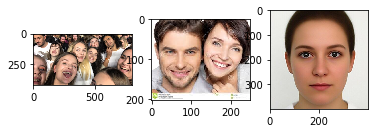

In [4]:
fig, axes = plt.subplots(1,3)

names_imgs = {}
for ind, (name, path) in enumerate(names_paths.items()):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    names_imgs[name] = img 

    # visualization
    axes[ind].imshow(img)
plt.show()
    

# [ 딥러닝 방법 : SSD(Single Shot MultiBox Detector) ] 
---


* Reference : [SSD: Single Shot MultiBox Detector](https://arxiv.org/pdf/1512.02325.pdf)

## 1. 모델 가져오기


### (1) Weights 및 모델 다운로드 하기

기 학습된 모형 graph 와 각 변수명에 해당하는 weights 을 다운로드 합니다.  
keras 는 모형의 graph와 weights 을 h5 파일에 한번에 저장할수 있습니다.  

In [5]:
from tensorflow.keras.models import load_model 
from tensorflow.keras.utils import get_file 
from tensorflow.keras import backend as K 

url = 'https://pai-datasets.s3.ap-northeast-2.amazonaws.com/face-recognition/SSD_face_detector.h5'
local_path = get_file("SSD_face_detector.h5", url)


### (2) 필수 Custom Layer 구성하기

`Single Shot Detector`을 불러오기 위해서는 `SSD`에 쓰인 Custom Layer을 불러와야 합니다.

In [6]:
from tensorflow.keras.layers import Layer 
from tensorflow.keras import backend as K 

class L2Normalization(Layer):
    def build(self, input_shape ):
        self.gamma = self.add_weight(name='gamma', shape=[input_shape[-1]])
        
    def call(self, inputs):
        output = K.l2_normalize(inputs, -1)
        return output * self.gamma
    

### (3) 모델 load 하기 

구성된 Custom Layer 을 load_model 에 지정해 줍니다. 

In [7]:
model = load_model(local_path, compile=False, custom_objects={'L2Normalization':L2Normalization})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### (4) 모델 확인해보기

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_bn1 (BatchNormalization) (None, 300, 300, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
block1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           block1_bn1[0][0]                 
__________________________________________________________________________________________________
block1_conv (Conv2D)            (None, 150, 150, 32) 4736        block1_pad[0][0]                 
______________________________________________________________________________________________

모델의 입력값은 (300,300) 사이즈로 고정되어 있고,

In [9]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 300, 300, 3) dtype=float32>

모델의 출력값은 총 6단계에 걸쳐서 나오게 됩니다.

In [10]:
model.output

[<tf.Tensor 'level0_out/concat:0' shape=(?, 38, 38, 4, 6) dtype=float32>,
 <tf.Tensor 'level1_out/concat:0' shape=(?, 19, 19, 6, 6) dtype=float32>,
 <tf.Tensor 'level2_out/concat:0' shape=(?, 10, 10, 6, 6) dtype=float32>,
 <tf.Tensor 'level3_out/concat:0' shape=(?, 5, 5, 6, 6) dtype=float32>,
 <tf.Tensor 'level4_out/concat:0' shape=(?, 3, 3, 4, 6) dtype=float32>,
 <tf.Tensor 'level5_out/concat:0' shape=(?, 1, 1, 4, 6) dtype=float32>]

각 단계 별 출력값은 아래와 구조를 가집니다.

$$(N_{batch}, H_{grid}, W_{grid}, N_{prior}, (d_{cx},d_{cy},d_{w},d_{h},conf_{bg}, conf_{fg}))$$

## 2. 모델을 통해 이미지 추론하기

### (1) 입력값 전처리하기

In [11]:
def preprocess_image(image):    
    # resize image
    image = cv2.resize(image, (300, 300))
    
    # 1. RGB to BGR
    image = image[:,:,::-1]
    
    # 2. subtract mean
    image = image - np.array((104.0, 177.0, 123.0))
    
    # 3. add batch axis
    image = image[None]
    
    return image

In [41]:
input_ = preprocess_image(names_imgs['crowd'])


### (2) 모델 추론하기

`Single Shot Multi Box Detector`의 출력값은 `Prior Boxes`로부터 얼마나 차이가 계산합니다.

![Imgur](https://i.imgur.com/UAzza0C.png)

In [47]:
print(len(model.predict(input_)))
model.output

6


[<tf.Tensor 'level0_out/concat:0' shape=(?, 38, 38, 4, 6) dtype=float32>,
 <tf.Tensor 'level1_out/concat:0' shape=(?, 19, 19, 6, 6) dtype=float32>,
 <tf.Tensor 'level2_out/concat:0' shape=(?, 10, 10, 6, 6) dtype=float32>,
 <tf.Tensor 'level3_out/concat:0' shape=(?, 5, 5, 6, 6) dtype=float32>,
 <tf.Tensor 'level4_out/concat:0' shape=(?, 3, 3, 4, 6) dtype=float32>,
 <tf.Tensor 'level5_out/concat:0' shape=(?, 1, 1, 4, 6) dtype=float32>]

In [57]:
model.predict(input_)[0][0,0,0,0,4:]

1.0

각 Prior Boxes와의 차이입니다.

$
\hat d^{cx} = \frac{(g^{cx} - p^{cx})}{p^{w}} \\
\hat d^{cy} = \frac{(g^{cy} - p^{cy})}{p^{h}} \\
\hat d^{w} = log(\frac{g^{w}}{p^{w}}) \\
\hat d^{h} = log(\frac{g^{h}}{p^{h}}) \\
$

#### Confidence 출력값($conf = (conf_{bg}, conf_{fg})$)



In [94]:
conf = stage0[...,4:] # 각 Prior Box의 Class
conf

array([[[[[0.918, 0.082],
          [0.925, 0.075],
          [0.921, 0.079],
          [0.918, 0.082]],

         [[0.919, 0.081],
          [0.93 , 0.07 ],
          [0.924, 0.076],
          [0.924, 0.076]],

         [[0.938, 0.062],
          [0.939, 0.061],
          [0.932, 0.068],
          [0.931, 0.069]],

         ...,

         [[0.912, 0.088],
          [0.92 , 0.08 ],
          [0.916, 0.084],
          [0.909, 0.091]],

         [[0.911, 0.089],
          [0.924, 0.076],
          [0.916, 0.084],
          [0.905, 0.095]],

         [[0.906, 0.094],
          [0.916, 0.084],
          [0.912, 0.088],
          [0.905, 0.095]]],


        [[[0.924, 0.076],
          [0.925, 0.075],
          [0.928, 0.072],
          [0.92 , 0.08 ]],

         [[0.917, 0.083],
          [0.922, 0.078],
          [0.925, 0.075],
          [0.918, 0.082]],

         [[0.921, 0.079],
          [0.917, 0.083],
          [0.923, 0.077],
          [0.924, 0.076]],

         ...,

         [[0.9

### (3) 좌표 복원하기

`prior box`는 일종의 Hyper Parameter로 모델을 설계할 때 고정된 값입니다. <br>
해당 모델에 대한 `Prior box`는 아래처럼 구성되어 있습니다.

In [23]:
import tensorflow as tf 

class DecodeBoxes(Layer):
    def __init__(self, 
                 box_step, 
                 box_sizes, 
                 variance=[0.1,0.1,0.2,0.2],
                 image_size=(300,300), 
                 **kwargs):
        self.box_step = box_step
        self.box_sizes = box_sizes
        self.variance = variance
        self.image_size = image_size
        super().__init__(**kwargs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "box_step": self.box_step,
            "box_sizes": self.box_sizes,
            "variance": self.variance,
            "image_size": self.image_size})
        return config    
    
    def call(self, inputs):
        variance = tf.constant(self.variance, tf.float32)
        delta_boxes = inputs[...,:4] * variance
        confidence = inputs[..., 5:]
        
        # 각 Grid 별 prior box의 중심 좌표 구하기
        ys = tf.range(0, self.image_size[0], self.box_step, tf.float32)
        ys = ys + self.box_step / 2.
        ys = ys / self.image_size[0]

        xs = tf.range(0, self.image_size[1], self.box_step, tf.float32)
        xs = xs + self.box_step / 2.
        xs = xs / self.image_size[1]
        prior_cx, prior_cy = tf.meshgrid(xs, ys)

        results = []
        for idx, box_size in enumerate(self.box_sizes):
            # 각 Grid 별 prior box의 Width, Height 구하기
            prior_w = tf.ones_like(prior_cx) * box_size[0] / self.image_size[1]
            prior_h = tf.ones_like(prior_cy) * box_size[1] / self.image_size[0]

            target_delta_boxes = delta_boxes[:,:,:,idx]
            d_cx, d_cy, d_w, d_h = tf.unstack(target_delta_boxes, axis=-1)

            decoded_cx = d_cx * prior_w + prior_cx
            decoded_cy = d_cy * prior_h + prior_cy
            decoded_w = tf.exp(d_w) * prior_w
            decoded_h = tf.exp(d_h) * prior_h

            decoded_xmin = decoded_cx - decoded_w / 2
            decoded_ymin = decoded_cy - decoded_h / 2
            decoded_xmax = decoded_cx + decoded_w / 2
            decoded_ymax = decoded_cy + decoded_h / 2        
            result = tf.stack(
                [decoded_xmin, decoded_ymin, 
                 decoded_xmax, decoded_ymax],axis=-1)
            results.append(result)

        boxes = tf.stack(results, axis=3)
        return tf.concat([boxes, confidence], axis=-1)        

#### Level0 복원하기

Level0에서는 가장 작은 얼굴들을 검출합니다. (width & height 기준 10% 크기의 얼굴)

In [24]:
from tensorflow.keras.models import Model

level0_priors = [[30., 30.], 
                 [42.426, 42.426], 
                 [42.426, 21.213],
                 [21.213, 42.426]]
level0_step = 8

level0_out = DecodeBoxes(level0_step, level0_priors)(model.output[0])

Level0 단계에서 잡는 얼굴은 어떤 것인지 한번 살펴보도록 하겠습니다.


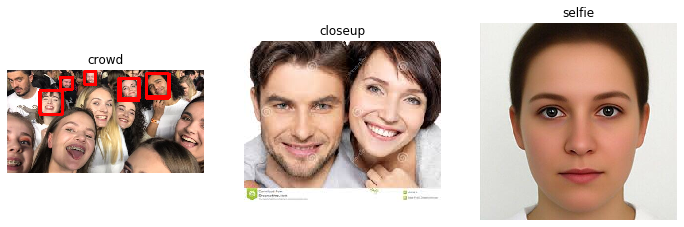

In [25]:
# 모델 구성하기
inference = Model(model.input, level0_out)

fig = plt.figure(figsize=(12,8))
for idx, (title, fpath) in enumerate(fpaths.items(),1):
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    keras_input = preprocess_image(image)

    result = inference.predict(keras_input)
    h, w = image.shape[:2]
    vis = image.copy()
    for box in result[result[...,-1]>0.3]:
        minx, miny, maxx, maxy = (box[:4] * [w, h, w, h]).astype(np.int)
        cv2.rectangle(vis, (minx, miny), (maxx, maxy), (255,0,0), 10)
    
    ax = fig.add_subplot(1,3,idx)
    ax.set_title(title)
    ax.imshow(vis)
    ax.axis('off')
plt.show()

#### Level1 복원하기

Leve1에서는 그다음 작은 얼굴들을 검출합니다. (width & height 기준 20% 크기의 얼굴)

In [26]:
level1_priors = [[ 60.   ,  60.   ],
                 [ 81.608,  81.608],
                 [ 84.853,  42.426],
                 [ 42.426,  84.853],
                 [103.923,  34.641],
                 [ 34.641, 103.923]]
level1_out = DecodeBoxes(16, level1_priors)(model.output[1])

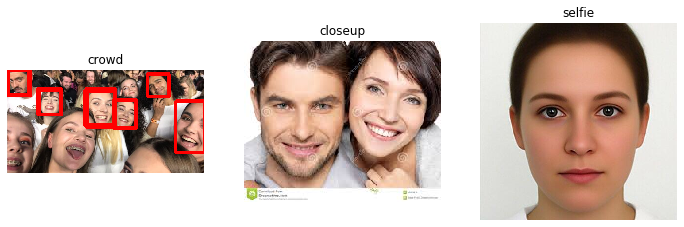

In [27]:
# 모델 구성하기
inference = Model(model.input, level1_out)

fig = plt.figure(figsize=(12,8))
for idx, (title, fpath) in enumerate(fpaths.items(),1):
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    keras_input = preprocess_image(image)

    result = inference.predict(keras_input)
    h, w = image.shape[:2]
    vis = image.copy()
    for box in result[result[...,-1]>0.3]:
        minx, miny, maxx, maxy = (box[:4] * [w, h, w, h]).astype(np.int)
        cv2.rectangle(vis, (minx, miny), (maxx, maxy), (255,0,0), 10)
    
    ax = fig.add_subplot(1,3,idx)
    ax.set_title(title)
    ax.imshow(vis)
    ax.axis('off')
plt.show()

#### Level2 복원하기

Leve2에서는 중간 사이즈 정도의 얼굴들을 검출합니다. (width & height 기준 40% 크기의 얼굴)

In [28]:
level2_priors = [[111.   , 111.   ],
                 [134.097, 134.097],
                 [156.978,  78.489],
                 [ 78.489, 156.978],
                 [192.258,  64.086],
                 [ 64.086, 192.258]]
level2_out = DecodeBoxes(32, level2_priors)(model.output[2])

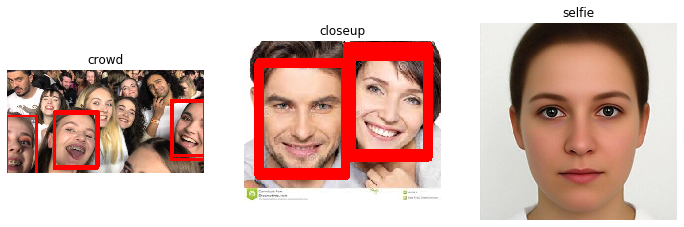

In [29]:
# 모델 구성하기
inference = Model(model.input, level2_out)

fig = plt.figure(figsize=(12,8))
for idx, (title, fpath) in enumerate(fpaths.items(),1):
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    keras_input = preprocess_image(image)

    result = inference.predict(keras_input)
    h, w = image.shape[:2]
    vis = image.copy()
    for box in result[result[...,-1]>0.3]:
        minx, miny, maxx, maxy = (box[:4] * [w, h, w, h]).astype(np.int)
        cv2.rectangle(vis, (minx, miny), (maxx, maxy), (255,0,0), 10)
    
    ax = fig.add_subplot(1,3,idx)
    ax.set_title(title)
    ax.imshow(vis)
    ax.axis('off')
plt.show()

#### Level3 복원하기

In [30]:
level3_priors = [[162.   , 162.   ],
                 [185.758, 185.758],
                 [229.103, 114.551],
                 [114.551, 229.103],
                 [280.592,  93.531],
                 [ 93.531, 280.592]]
level3_out = DecodeBoxes(64, level3_priors)(model.output[3])

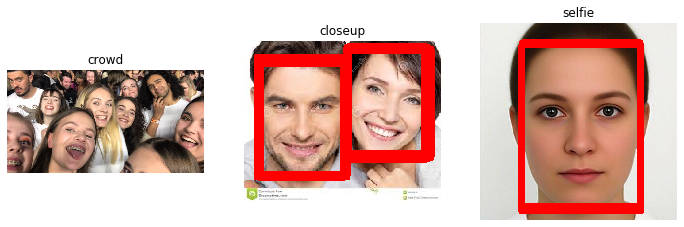

In [31]:
# 모델 구성하기
inference = Model(model.input, level3_out)

fig = plt.figure(figsize=(12,8))
for idx, (title, fpath) in enumerate(fpaths.items(),1):
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    keras_input = preprocess_image(image)

    result = inference.predict(keras_input)
    h, w = image.shape[:2]
    vis = image.copy()
    for box in result[result[...,-1]>0.3]:
        minx, miny, maxx, maxy = (box[:4] * [w, h, w, h]).astype(np.int)
        cv2.rectangle(vis, (minx, miny), (maxx, maxy), (255,0,0), 10)
    
    ax = fig.add_subplot(1,3,idx)
    ax.set_title(title)
    ax.imshow(vis)
    ax.axis('off')
plt.show()

#### Level4 복원하기

In [32]:
level4_priors = [[213.   , 213.   ],
                 [237.133, 237.133],
                 [301.227, 150.614],
                 [150.614, 301.227]]
level4_step = 100
level4_out = DecodeBoxes(level4_step, level4_priors)(model.output[4])

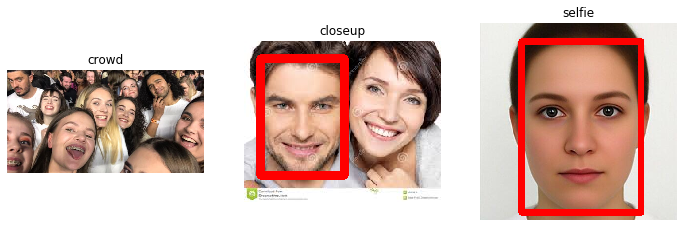

In [33]:
# 모델 구성하기
inference = Model(model.input, level4_out)

fig = plt.figure(figsize=(12,8))
for idx, (title, fpath) in enumerate(fpaths.items(),1):
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    keras_input = preprocess_image(image)

    result = inference.predict(keras_input)
    h, w = image.shape[:2]
    vis = image.copy()
    for box in result[result[...,-1]>0.3]:
        minx, miny, maxx, maxy = (box[:4] * [w, h, w, h]).astype(np.int)
        cv2.rectangle(vis, (minx, miny), (maxx, maxy), (255,0,0), 10)
    
    ax = fig.add_subplot(1,3,idx)
    ax.set_title(title)
    ax.imshow(vis)
    ax.axis('off')
plt.show()

#### Level5 복원하기

In [34]:
level5_priors = [[264.   , 264.   ],
                 [288.375, 288.375],
                 [373.352, 186.676],
                 [186.676, 373.352]]
level5_step = 300

level5_out = DecodeBoxes(level5_step, level5_priors)(model.output[5])

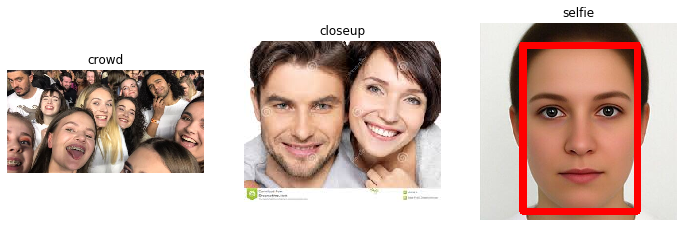

In [35]:
# 모델 구성하기
inference = Model(model.input, level5_out)

fig = plt.figure(figsize=(12,8))
for idx, (title, fpath) in enumerate(fpaths.items(),1):
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    keras_input = preprocess_image(image)

    result = inference.predict(keras_input)
    h, w = image.shape[:2]
    vis = image.copy()
    for box in result[result[...,-1]>0.3]:
        minx, miny, maxx, maxy = (box[:4] * [w, h, w, h]).astype(np.int)
        cv2.rectangle(vis, (minx, miny), (maxx, maxy), (255,0,0), 10)
    
    ax = fig.add_subplot(1,3,idx)
    ax.set_title(title)
    ax.imshow(vis)
    ax.axis('off')
plt.show()

### (4) 결과를 수합하기

In [36]:
level0_priors = [[30., 30.], 
                 [42.426, 42.426], 
                 [42.426, 21.213],
                 [21.213, 42.426]]
level0_step = 8
level0_out = DecodeBoxes(level0_step, level0_priors)(model.output[0])

level1_priors = [[ 60.   ,  60.   ],
                 [ 81.608,  81.608],
                 [ 84.853,  42.426],
                 [ 42.426,  84.853],
                 [103.923,  34.641],
                 [ 34.641, 103.923]]
level0_step = 16
level1_out = DecodeBoxes(level0_step, level1_priors)(model.output[1])

level2_priors = [[111.   , 111.   ],
                 [134.097, 134.097],
                 [156.978,  78.489],
                 [ 78.489, 156.978],
                 [192.258,  64.086],
                 [ 64.086, 192.258]]
level2_step = 32
level2_out = DecodeBoxes(level2_step, level2_priors)(model.output[2])

level3_priors = [[162.   , 162.   ],
                 [185.758, 185.758],
                 [229.103, 114.551],
                 [114.551, 229.103],
                 [280.592,  93.531],
                 [ 93.531, 280.592]]
level3_step = 64
level3_out = DecodeBoxes(level3_step, level3_priors)(model.output[3])

level4_priors = [[213.   , 213.   ],
                 [237.133, 237.133],
                 [301.227, 150.614],
                 [150.614, 301.227]]
level4_step = 100
level4_out = DecodeBoxes(level4_step, level4_priors)(model.output[4])

level5_priors = [[264.   , 264.   ],
                 [288.375, 288.375],
                 [373.352, 186.676],
                 [186.676, 373.352]]
level5_step = 300
level5_out = DecodeBoxes(level5_step, level5_priors)(model.output[5])

하나의 출력값으로 한번에 나오게 만들기 위해 우리는 합쳐주도록 하겠습니다.

In [37]:
from tensorflow.keras.layers import Reshape, Concatenate

In [38]:
level0_reshaped = Reshape((-1,5))(level0_out)
level1_reshaped = Reshape((-1,5))(level1_out)
level2_reshaped = Reshape((-1,5))(level2_out)
level3_reshaped = Reshape((-1,5))(level3_out)
level4_reshaped = Reshape((-1,5))(level4_out)
level5_reshaped = Reshape((-1,5))(level5_out)

predictions = Concatenate(axis=1)([level0_reshaped, level1_reshaped, 
                                   level2_reshaped, level3_reshaped, 
                                   level4_reshaped, level5_reshaped])

inference = Model(model.inputs, predictions)

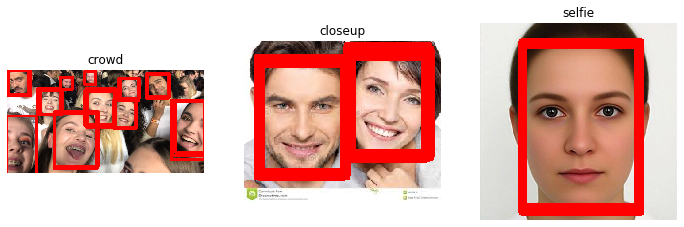

In [39]:
fig = plt.figure(figsize=(12,8))
for idx, (title, fpath) in enumerate(fpaths.items(),1):
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    keras_input = preprocess_image(image)

    result = inference.predict(keras_input)
    h, w = image.shape[:2]
    vis = image.copy()
    for box in result[result[...,-1]>0.3]:
        minx, miny, maxx, maxy = (box[:4] * [w, h, w, h]).astype(np.int)
        cv2.rectangle(vis, (minx, miny), (maxx, maxy), (255,0,0), 10)
    
    ax = fig.add_subplot(1,3,idx)
    ax.set_title(title)
    ax.imshow(vis)
    ax.axis('off')
plt.show()

머신러닝 방식보다 훨씬 더 잘 잡는다는 것을 알 수 있습니다. 하지만 이 때 유심히 봐야하는 것 중 하나는 바로 결과에 중첩이 매우 많다는 것입니다. <br>
이는 딥러닝 Object Detection 모델 대부분이 가지고 있는 특성으로 여러 점으로부터 하나의 객체를 동시다발적으로 검출하기 때문입니다. <br>
그렇기 때문에, 겹친 Bounding Box를 제거하는 후처리 과정이 필수입니다. 이러한 후처리 알고리즘으로 대표되는 것이 바로 Non-Maximum-Suppression입니다. 

#  

---

    Copyright(c) 2020 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2020/03/19

---